In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:sim.faassim:initializing simulation, benchmark: ConstantBenchmark, topology nodes: 338
INFO:sim.faassim:starting resource monitor
INFO:sim.faassim:setting up benchmark
INFO:root:faas-workloads/resnet-inference-cpu, latest, [ImageProperties(name='faas-workloads/resnet-inference-cpu', size=2000000000, tag='latest', arch='x86'), ImageProperties(name='faas-workloads/resnet-inference-cpu', size=2000000000, tag='latest', arch='amd64'), ImageProperties(name='faas-workloads/resnet-inference-cpu', size=700000000, tag='latest', arch='arm32v7'), ImageProperties(name='faas-workloads/resnet-inference-cpu', size=700000000, tag='latest', arch='arm32'), ImageProperties(name='faas-workloads/resnet-inference-cpu', size=700000000, tag='latest', arch='arm'), ImageProperties(name='faas-workloads/resnet-inference-cpu', size=840000000, tag='latest', arch='aarch64'), ImageProperties(name='faas-workloads/resnet-inference-cpu', size=840000000, tag='latest', arch='arm64')]
INFO:root:faas-workloads/resnet-in

INFO:sim.faas.system:pod pod-speech-inference-141 was scheduled to rpi3_755
INFO:sim.faas.system:pod pod-speech-inference-142 was scheduled to rpi4_702
INFO:sim.faas.system:scale down speech-inference by 1
INFO:sim.faas.system:pod pod-speech-inference-143 was scheduled to rpi4_702
INFO:sim.faas.system:pod pod-speech-inference-144 was scheduled to rpi4_703
INFO:sim.faas.system:scale down speech-inference by 1
INFO:sim.faas.system:pod pod-speech-inference-145 was scheduled to rpi4_703
INFO:sim.faas.system:scale down speech-inference by 1
INFO:sim.faas.system:pod pod-speech-inference-146 was scheduled to rpi4_703
INFO:sim.faas.system:scale down speech-inference by 1
INFO:sim.faas.system:pod pod-speech-inference-147 was scheduled to rpi4_703
INFO:sim.faas.system:pod pod-speech-inference-148 was scheduled to rpi4_700
INFO:sim.faassim:simulation ran 10175.00s sim, 2.45s wall


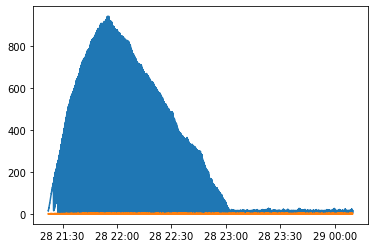

(array([7731.,   66.,   43.,   57.,   61.,   52.,   65.,   51.,   70.,
          33.,   57.,   61.,   55.,   40.,   47.,   62.,   65.,   94.,
          92.,   71.,   75.,   63.,   54.,   31.,   10.,   38.,   27.,
          29.,   20.,   30.,   35.,   29.,   30.,   36.,   32.,   37.,
          20.,   43.,   28.,   35.,   26.,   29.,   16.,   51.,   55.,
          38.,   51.,   43.,   47.,   25.]),
 array([  6.625772  ,  25.29757655,  43.9693811 ,  62.64118566,
         81.31299021,  99.98479476, 118.65659931, 137.32840387,
        156.00020842, 174.67201297, 193.34381753, 212.01562208,
        230.68742663, 249.35923118, 268.03103574, 286.70284029,
        305.37464484, 324.04644939, 342.71825395, 361.3900585 ,
        380.06186305, 398.73366761, 417.40547216, 436.07727671,
        454.74908126, 473.42088582, 492.09269037, 510.76449492,
        529.43629948, 548.10810403, 566.77990858, 585.45171313,
        604.12351769, 622.79532224, 641.46712679, 660.13893135,
        678.8107359 , 69

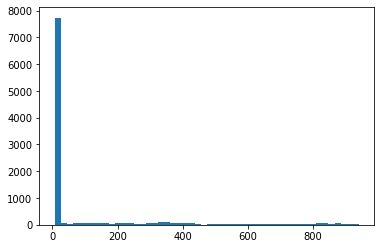

In [40]:
import logging
import random

import numpy as np
from skippy.core.scheduler import Scheduler
from skippy.core.storage import StorageIndex

from ext.raith21 import images
from ext.raith21.benchmark.constant import ConstantBenchmark
from ext.raith21.characterization import get_raith21_function_characterizations
from ext.raith21.deployments import create_all_deployments
from ext.raith21.etherdevices import convert_to_ether_nodes
from ext.raith21.fet import ai_execution_time_distributions
from ext.raith21.functionsim import AIPythonHTTPSimulatorFactory
from ext.raith21.generator import generate_devices
from ext.raith21.generators.cloudcpu import cloudcpu_settings
from ext.raith21.oracles import Raith21ResourceOracle, Raith21FetOracle
from ext.raith21.predicates import CanRunPred, NodeHasAcceleratorPred, NodeHasFreeGpu, NodeHasFreeTpu
from ext.raith21.resources import ai_resources_per_node_image
from ext.raith21.topology import urban_sensing_topology
from ext.raith21.util import vanilla
from sim.core import Environment
from sim.docker import ContainerRegistry
from sim.faas.system import DefaultFaasSystem
from sim.faassim import Simulation
from sim.logging import SimulatedClock, RuntimeLogger
from sim.metrics import Metrics
from sim.skippy import SimulationClusterContext
import matplotlib.pyplot as plt
import pickle

np.random.seed(1234)
random.seed(1234)
logging.basicConfig(level=logging.INFO)

num_devices = 100
devices = generate_devices(num_devices, cloudcpu_settings)
# print(devices)
ether_nodes = convert_to_ether_nodes(devices)

fet_oracle = Raith21FetOracle(ai_execution_time_distributions)
resource_oracle = Raith21ResourceOracle(ai_resources_per_node_image)

deployments = list(create_all_deployments(fet_oracle, resource_oracle).values())
function_images = images.all_ai_images

predicates = []
predicates.extend(Scheduler.default_predicates)
predicates.extend([
    CanRunPred(fet_oracle, resource_oracle),
    NodeHasAcceleratorPred(),
    NodeHasFreeGpu(),
    NodeHasFreeTpu()
])

priorities = vanilla.get_priorities()

sched_params = {
    'percentage_of_nodes_to_score': 100,
    'priorities': priorities,
    'predicates': predicates
}

# Set arrival profiles/workload pattern
benchmark = ConstantBenchmark('mixed', duration=10000, rps=1)

# Initialize topology
storage_index = StorageIndex()
topology = urban_sensing_topology(ether_nodes, storage_index)

# Initialize environment
env = Environment()

env.simulator_factory = AIPythonHTTPSimulatorFactory(
    get_raith21_function_characterizations(resource_oracle, fet_oracle))
env.metrics = Metrics(env, log=RuntimeLogger(SimulatedClock(env)))
env.topology = topology
env.faas = DefaultFaasSystem(env, scale_by_queue_requests_per_replica=True)
env.container_registry = ContainerRegistry()
env.storage_index = storage_index
env.cluster = SimulationClusterContext(env)
env.scheduler = Scheduler(env.cluster, **sched_params)

sim = Simulation(env.topology, benchmark, env=env)
result = sim.run()

dfs = {
    "invocations_df": sim.env.metrics.extract_dataframe('invocations'),
    "scale_df": sim.env.metrics.extract_dataframe('scale'),
    "schedule_df": sim.env.metrics.extract_dataframe('schedule'),
    "replica_deployment_df": sim.env.metrics.extract_dataframe('replica_deployment'),
    "function_deployments_df": sim.env.metrics.extract_dataframe('function_deployments'),
    "function_deployment_df": sim.env.metrics.extract_dataframe('function_deployment'),
    "function_deployment_lifecycle_df": sim.env.metrics.extract_dataframe('function_deployment_lifecycle'),
    "functions_df": sim.env.metrics.extract_dataframe('functions'),
    "flow_df": sim.env.metrics.extract_dataframe('flow'),
    "network_df": sim.env.metrics.extract_dataframe('network'),
    "utilization_df": sim.env.metrics.extract_dataframe('utilization'),
    'fets_df': sim.env.metrics.extract_dataframe('fets')
}

inv = dfs['invocations_df']
plt.plot(inv.index, inv['t_exec'])
plt.plot(inv.index, inv['t_exec'].rolling('1s').count())
# plt.plot(inv.index, inv['t_exec'].rolling('5s').count() / 5)



plt.show()
plt.hist(inv['t_exec'])

In [27]:
rd = dfs['replica_deployment_df']
rd = rd[rd['function_name'] == 'speech-inference']
rd

,value,function_name,node_name,replica_id
time,,,,
2021-05-28 21:01:54.484144,deploy,speech-inference,rockpi_44,140564378506704
2021-05-28 21:02:20.827102,startup,speech-inference,rockpi_44,140564378506704
2021-05-28 21:02:20.827102,setup,speech-inference,rockpi_44,140564378506704
2021-05-28 21:02:23.998900,finish,speech-inference,rockpi_44,140564378506704
2021-05-28 21:03:34.399585,deploy,speech-inference,rockpi_42,140564271155152
2021-05-28 21:03:34.439881,deploy,speech-inference,rockpi_42,140564271153232
2021-05-28 21:03:34.439881,startup,speech-inference,rockpi_42,140564271153232
2021-05-28 21:03:34.439881,setup,speech-inference,rockpi_42,140564271153232
2021-05-28 21:03:37.611893,finish,speech-inference,rockpi_42,140564271153232


/home/jp/Documents/GitProjects/faas-sim/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


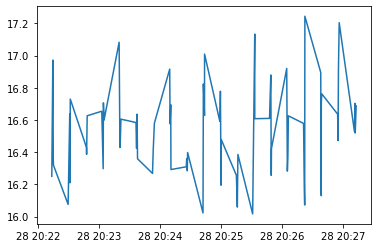

In [8]:
fets = dfs['fets_df']
fets = fets[fets['function_name'] == 'speech-inference']
fets['exc'] = fets['t_fet_end'] - fets['t_fet_start']
fets
plt.plot(fets.index, fets['exc'])
plt.show()